In [239]:
import pandas as pd
import numpy as np

test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')
sub = pd.read_csv('data/sample_submission.csv')

In [240]:
import os
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정

### Data Preprocessing

In [241]:
train = pd.concat([train,train.iloc[:,6:95].T.describe().T.drop('count',axis=1)],axis=1)
test = pd.concat([test,test.iloc[:,5:94].T.describe().T.drop('count',axis=1)],axis=1)

#### Oversampling

In [188]:
# ## suppress install output

# ## install pypi release
# !pip install smogn

# ## install developer version
# !pip install git+https://github.com/nickkunz/smogn.git

In [256]:
import smogn
import seaborn

In [276]:
## specify phi relevance values
rg_mtrx = [
    [200,  1, 0],  ## over-sample ("minority")
    [400, 0, 1],  ## under-sample ("majority")
    [600, 0, 1],  ## under-sample
    [800, 1, 0],  ## under-sample
]

In [277]:
## conduct smogn
X_s = smogn.smoter(
    ## main arguments
    data = train.drop('ID',axis=1),           ## pandas dataframe
    y = '착과량(int)',          ## string ('header name')
    k = 7,                    ## positive integer (k < n)
    pert = 0.04,              ## real number (0 < R < 1)
    samp_method = 'balance',  ## string ('balance' or 'extreme')
    drop_na_col = True,       ## boolean (True or False)
    drop_na_row = True,       ## boolean (True or False)
    replace = False,          ## boolean (True or False)

    ## phi relevance arguments
    rel_thres = 0.10,         ## real number (0 < R < 1)
    # 0.10 -> 1983, # 0.15 -> 2074
    rel_method = 'manual',    ## string ('auto' or 'manual')
    # rel_xtrm_type = 'both', ## unused (rel_method = 'manual')
    # rel_coef = 1.50,        ## unused (rel_method = 'manual')
    rel_ctrl_pts_rg = rg_mtrx ## 2d array (format: [x, y])
)

/home/work/.local/lib/python3.8/site-packages/smogn/smoter.py:201: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  b_index.update({i: y_sort[bumps[i]:bumps[i + 1]]})
dist_matrix: 100% 394/394 [05:59<00:00,  1.09it/s]
r_index: 100% 342/342 [00:03<00:00, 98.86it/s] 


ValueError: oops! synthetic data contains missing values

In [ ]:
## distribution plot
seaborn.kdeplot(train['착과량(int)'], label="Original")
seaborn.kdeplot(X_s['착과량(int)'], label="Modified")

In [ ]:
seaborn.kdeplot(X_s['착과량(int)'], label="Modified")

<AxesSubplot:xlabel='착과량(int)', ylabel='Density'>

/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 52265 (\N{HANGUL SYLLABLE CAG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52265 (\N{HANGUL SYLLABLE CAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLA

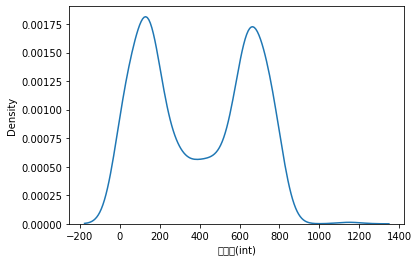

In [275]:
seaborn.kdeplot(X_s['착과량(int)'], label="Modified")

In [261]:
# ###################코드 돌아가면 소리 나는거################### 
# import winsound as sd
# def beepsound():
#     fr = 2000    # range : 37 ~ 32767
#     du = 1000     # 1000 ms ==1second
#     sd.Beep(fr, du) # winsound.Beep(frequency, duration)
# beepsound()
# ##############################################################

#### Data split

In [262]:
train_data = pd.concat([train.drop('ID',axis=1), X_s], axis=0).reset_index(drop=True)

In [263]:
x_train = train_data.drop(['착과량(int)'],axis=1)
y_train = train_data['착과량(int)']
x_test = test.drop(['ID'],axis=1)

#### Data Scaler

In [264]:
col_lst = x_train.columns

In [265]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

scaler = StandardScaler()
# scaler = RobustScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train=pd.DataFrame(x_train,columns=col_lst)
x_test=pd.DataFrame(x_test,columns=col_lst)

### Feature Selection

In [266]:
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import cross_val_score

from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt

100% 95/95 [00:09<00:00, 10.21it/s]


(24, -33.727977538742046)


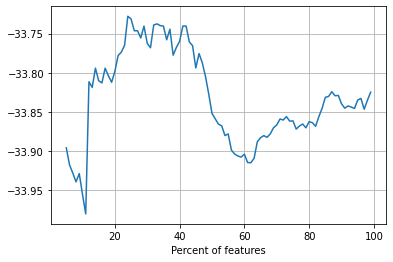

In [267]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = Ridge(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(x_train, y_train)    #SelectPercentile: 지정된 비율만큼 특성을 선택한다.
    cv_score = cross_val_score(model, X_new, y_train, scoring='neg_mean_absolute_error', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [268]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(x_train, y_train)
x_train_select = fs.transform(x_train)
x_test_select = fs.transform(x_test)

In [269]:
print(x_train_select.shape)
print(x_train.columns[fs.get_support()].tolist())
# ['새순_mean_9', '새순_50_9', '새순_75_9', '새순_max_9', '새순_mean_9_2', 
# '새순_75_9_2', '새순_max_9_2', '2022-09-01 새순', '2022-09-02 새순', 
# '2022-09-03 새순', '2022-09-04 새순', '2022-09-05 새순', '2022-09-06 새순', 
# '2022-09-07 새순']

(4190, 46)
['2022-09-01 새순', '2022-09-02 새순', '2022-09-03 새순', '2022-09-04 새순', '2022-09-05 새순', '2022-09-06 새순', '2022-09-07 새순', '2022-09-08 새순', '2022-09-09 새순', '2022-09-10 새순', '2022-09-11 새순', '2022-09-12 새순', '2022-09-13 새순', '2022-09-14 새순', '2022-09-15 새순', '2022-09-16 새순', '2022-09-17 새순', '2022-09-18 새순', '2022-09-19 새순', '2022-09-20 새순', '2022-09-21 새순', '2022-09-22 새순', '2022-09-23 새순', '2022-09-24 새순', '2022-09-25 새순', '2022-09-26 새순', '2022-09-27 새순', '2022-09-28 새순', '2022-09-29 새순', '2022-09-30 새순', '2022-10-01 새순', '2022-10-02 새순', '2022-10-03 새순', '2022-10-04 새순', '2022-10-05 새순', '2022-10-06 새순', '2022-10-07 새순', '2022-10-08 새순', '2022-10-09 새순', '2022-10-10 새순', '2022-10-11 새순', '2022-10-13 새순', 'mean', 'std', '75%', 'max']


In [271]:
x_train_select = pd.DataFrame(x_train_select, columns =x_train.columns[fs.get_support()].tolist())
x_test_select = pd.DataFrame(x_test_select, columns =x_test.columns[fs.get_support()].tolist())

In [23]:
# pd.concat([x_train_select,y_train],axis=1).corr()

### Modeling

In [26]:
# !pip install --upgrade ngboost

/usr/local/lib/python3.8/dist-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/local/lib/python3.8/dist-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 KB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 76.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 80.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.7/349.7 KB 110.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 86.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 KB 26.2 MB/s eta 0:00:00

In [272]:
from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal
from ngboost.scores import MLE
from ngboost.learners import default_tree_learner
from sklearn.model_selection import train_test_split


def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

/usr/local/lib/python3.8/dist-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [273]:
##### 0.07362
ngb = NGBRegressor(n_estimators=20000,  natural_gradient=True, 
                   learning_rate = 0.01,Base=default_tree_learner, 
                   Dist=Normal, Score=MLE, verbose_eval =50, random_state=0)

kf = KFold(n_splits = 5, shuffle=True, random_state=0)
ngb_pred_1 = np.zeros((x_test_select.shape[0]))
nmae_list = []
for tr_idx, val_idx in kf.split(x_train_select):
    tr_x, val_x = x_train_select.iloc[tr_idx], x_train_select.iloc[val_idx]
    tr_y, val_y = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    ngb.fit(tr_x, tr_y, val_x, val_y, early_stopping_rounds = 500)
    pred = ngb.predict(val_x)
    nmae = NMAE(val_y, pred)
    nmae_list.append(nmae)
    print(f'FOLD NMAE = {nmae}')
    sub_pred = ngb.predict(x_test_select) / 5
    ngb_pred_1 += sub_pred
print(f'\n{ngb.__class__.__name__} NMAE = {np.mean(nmae_list)}')

[iter 0] loss=6.9138 val_loss=6.9150 scale=1.0000 norm=216.6612
[iter 50] loss=6.2751 val_loss=6.2739 scale=2.0000 norm=169.4432
[iter 100] loss=5.8126 val_loss=5.8153 scale=2.0000 norm=78.4720
[iter 150] loss=5.4218 val_loss=5.4356 scale=2.0000 norm=58.8779
[iter 200] loss=5.1361 val_loss=5.1746 scale=2.0000 norm=55.4111
[iter 250] loss=4.9684 val_loss=5.0473 scale=2.0000 norm=54.3092
[iter 300] loss=4.8865 val_loss=5.0223 scale=2.0000 norm=53.4884
[iter 350] loss=4.8496 val_loss=5.0355 scale=1.0000 norm=26.4585
[iter 400] loss=4.8249 val_loss=5.0612 scale=2.0000 norm=52.4402
[iter 450] loss=4.8066 val_loss=5.0866 scale=2.0000 norm=51.9742
[iter 500] loss=4.7925 val_loss=5.1098 scale=1.0000 norm=25.7891
[iter 550] loss=4.7821 val_loss=5.1351 scale=2.0000 norm=51.2896
[iter 600] loss=4.7720 val_loss=5.1470 scale=1.0000 norm=25.4552
[iter 650] loss=4.7623 val_loss=5.1565 scale=2.0000 norm=50.5909
[iter 700] loss=4.7519 val_loss=5.1620 scale=1.0000 norm=25.1312
[iter 750] loss=4.7421 val

/home/work/.local/lib/python3.8/site-packages/ngboost/distns/normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2


[iter 0] loss=4.8701 val_loss=4.7468 scale=1.0000 norm=25.8803
[iter 50] loss=4.7669 val_loss=4.7387 scale=1.0000 norm=25.5320
[iter 100] loss=4.7520 val_loss=4.7315 scale=2.0000 norm=50.6509
[iter 150] loss=4.7420 val_loss=4.7277 scale=2.0000 norm=50.3319
[iter 200] loss=4.7329 val_loss=4.7255 scale=1.0000 norm=25.0167
[iter 250] loss=4.7229 val_loss=4.7231 scale=1.0000 norm=24.8578
[iter 300] loss=4.7142 val_loss=4.7213 scale=1.0000 norm=24.7103
[iter 350] loss=4.7054 val_loss=4.7192 scale=0.5000 norm=12.2815
[iter 400] loss=4.6970 val_loss=4.7194 scale=2.0000 norm=48.8629
[iter 450] loss=4.6902 val_loss=4.7195 scale=1.0000 norm=24.3054
[iter 500] loss=4.6837 val_loss=4.7203 scale=1.0000 norm=24.1911
[iter 550] loss=4.6780 val_loss=4.7203 scale=2.0000 norm=48.1833
[iter 600] loss=4.6720 val_loss=4.7205 scale=1.0000 norm=23.9795
[iter 650] loss=4.6652 val_loss=4.7209 scale=0.5000 norm=11.9313
[iter 700] loss=4.6592 val_loss=4.7211 scale=0.5000 norm=11.8818
[iter 750] loss=4.6527 val_l

KeyboardInterrupt: 

In [49]:
# ngb = NGBRegressor(n_estimators=20000,  natural_gradient=True, 
#                    learning_rate = 0.01,Base=default_tree_learner, 
#                    Dist=Normal, Score=MLE, verbose_eval =50)

# X_train, X_test, Y_train, Y_test = train_test_split(x_train_select, y_train, test_size=0.3, random_state=42)

# ngb.fit(X_train, Y_train,X_test,Y_test, early_stopping_rounds = 500)
# ngb_pred_1 = ngb.predict(x_test_select)

In [30]:
sub['착과량(int)'] = ngb_pred_1
sub['착과량(int)'].describe()
# 0.06668567243049171

count    2208.000000
mean      394.928890
std       212.962894
min        15.551683
25%       241.120666
50%       369.029957
75%       557.529060
max       780.944506
Name: 착과량(int), dtype: float64

In [31]:
sub_7362 = pd.read_csv('sub/1213_v5.csv')
sub_7362['착과량(int)'].describe()
# 0.06668567243049171

count    2208.000000
mean      394.953472
std       212.973437
min        15.577507
25%       240.986809
50%       368.969855
75%       557.553524
max       780.769775
Name: 착과량(int), dtype: float64

### Make_submission

In [79]:
sub

,ID,착과량(int)
0,TEST_0000,243.735389
1,TEST_0001,759.005036
2,TEST_0002,143.644990
3,TEST_0003,447.129684
4,TEST_0004,685.386048
...,...,...
2203,TEST_2203,754.079877
2204,TEST_2204,313.763077
2205,TEST_2205,367.961946
2206,TEST_2206,250.637846


In [80]:
sub.set_index('ID').to_csv('sub/1213_v8.csv')